In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
 
with open('sequence.fasta','r') as f:
    _ = f.readline()
    sequence_wt = f.readline().strip()
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test  = np.load('X_test.npy')
X_train = np.load('X_train2.npy')
y_train = np.load('y_train2.npy')
X_test  = np.load('X_test2.npy')
X_train = np.load('X_train3.npy')
y_train = np.load('y_train3.npy')
X_test  = np.load('X_test3.npy')
 
class ESMPredictor:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
        self.model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
        self.model.eval()
    def get_mutation_score(self, sequence_wt, mutation):
        wt, pos, mt = mutation[0], int(mutation[1:-1]), mutation[-1]
        masked = sequence_wt[:pos-1] + self.tokenizer.mask_token + sequence_wt[pos:]
        inputs = self.tokenizer(masked, return_tensors="pt").to(device)
        mask_idx = (inputs["input_ids"] == self.tokenizer.mask_token_id).nonzero()[0,1]
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probs = F.softmax(logits[0,mask_idx], dim=-1)
        wt_tok = self.tokenizer.convert_tokens_to_ids(wt)
        mt_tok = self.tokenizer.convert_tokens_to_ids(mt)
        return (probs[mt_tok] - probs[wt_tok]).item()
 
 
class FeatureExtractor:
    def __init__(self, sequence_wt):
        self.sequence_wt = sequence_wt
        self.esm = ESMPredictor()
        aas = 'ACDEFGHIKLMNPQRSTVWY'
        self.aa2idx = {aa:i for i,aa in enumerate(aas)}
        self.alen = len(aas)
        self.seqlen = len(sequence_wt)
    def get_features(self, df):
        feats = []
        for mut in df['mutant']:
            wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]
            pf = [pos/self.seqlen,
                  self.aa2idx[wt]/self.alen,
                  self.aa2idx[mt]/self.alen]
            try:
                esm_score = self.esm.get_mutation_score(self.sequence_wt, mut)
            except:
                esm_score = 0.0
            feats.append(pf + [esm_score])
        return np.vstack(feats)
 
 
train_df = pd.read_csv('train.csv')
 
if os.path.exists('query_output.txt'):
    df_query = pd.read_csv('query_output.txt')
    train_df = pd.concat([train_df, df_query[["mutant", "DMS_score"]]]).reset_index(drop=True)
if os.path.exists('query_output_2.txt'):
    df_query = pd.read_csv('query_output_2.txt')
    train_df = pd.concat([train_df, df_query[["mutant", "DMS_score"]]]).reset_index(drop=True)
if os.path.exists('query_output_3.txt'):
    df_query = pd.read_csv('query_output_3.txt')
    train_df = pd.concat([train_df, df_query[["mutant", "DMS_score"]]]).reset_index(drop=True)
 
test_df  = pd.read_csv('test.csv')
 
 
fe = FeatureExtractor(sequence_wt)
# X_train = fe.get_features(train_df)
# y_train = train_df['DMS_score'].values
# X_test  = fe.get_features(test_df)
 
# np.save('X_train3.npy', X_train)
# np.save('y_train3.npy', y_train)
# np.save('X_test3.npy',  X_test)

/home/hice1/aanna7/.conda/envs/mlb/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(100, 1240)
(100, 11324)


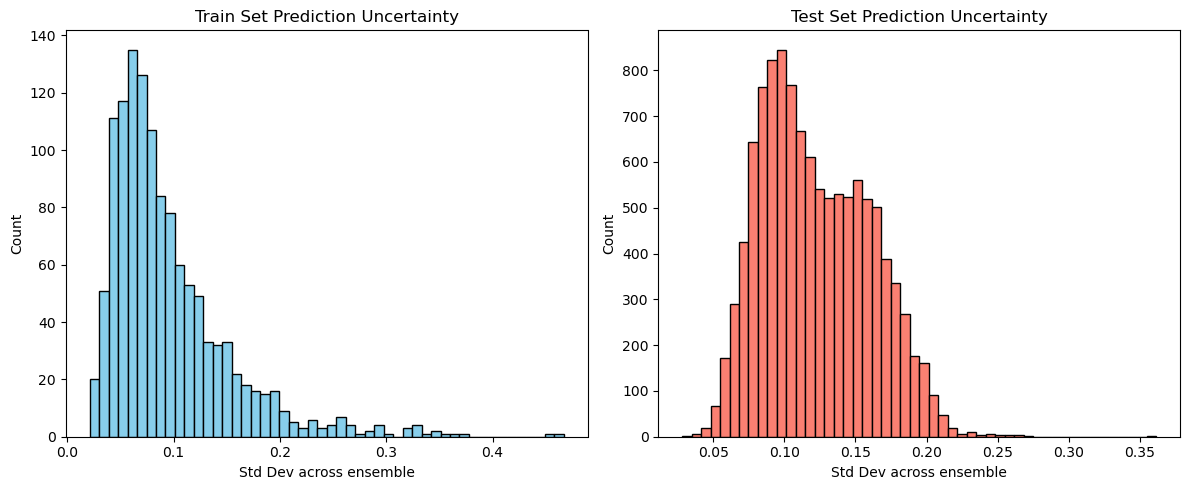

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
 
n_models = 100
preds_train = np.zeros((n_models, X_train.shape[0]))
print(preds_train.shape)
preds_test  = np.zeros((n_models, X_test.shape[0]))
print(preds_test.shape)
 
for i in range(n_models):
 
    idxs = np.random.choice(len(X_train), size=len(X_train), replace=True)
    Xb, yb = X_train[idxs], y_train[idxs]
    
    m = xgb.XGBRegressor(
        n_estimators=5000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42 + i,
        # tree_method='exact',
    )
    m.fit(Xb, yb, verbose=False)
    
 
    preds_train[i] = m.predict(X_train)
    preds_test[i]  = m.predict(X_test)
 
 
mean_train = preds_train.mean(axis=0)
std_train  = preds_train.std(axis=0)
 
mean_test = preds_test.mean(axis=0)
std_test  = preds_test.std(axis=0)
 
train_df['predicted']   = mean_train
train_df['uncertainty'] = std_train
 
test_df['predicted']    = mean_test
test_df['uncertainty']  = std_test
 
 
out = pd.DataFrame({
    'mutant': test_df['mutant'],
    'DMS_score_predicted': mean_test
})
out.to_csv('predictions.csv', index=False)
 
plt.figure(figsize=(12,5))
 
plt.subplot(1,2,1)
plt.hist(std_train, bins=50, color='skyblue', edgecolor='k')
plt.title('Train Set Prediction Uncertainty')
plt.xlabel('Std Dev across ensemble')
plt.ylabel('Count')
 
plt.subplot(1,2,2)
plt.hist(std_test, bins=50, color='salmon', edgecolor='k')
plt.title('Test Set Prediction Uncertainty')
plt.xlabel('Std Dev across ensemble')
plt.ylabel('Count')
 
plt.tight_layout()
plt.show()

In [9]:
test_df.sort_values(by=['predicted'], ascending=False).iloc[:10, :]

,mutant,predicted,uncertainty
10249,E599M,0.965325,0.025453
9979,E585T,0.953397,0.021693
9825,V577T,0.950509,0.043308
9853,S578K,0.948876,0.040565
10291,E601V,0.947024,0.013074
10037,A588T,0.941149,0.056121
9832,V577F,0.941091,0.033149
10250,E599N,0.937461,0.025935
8999,L533I,0.936945,0.076652
10200,K596Y,0.935841,0.076184


In [12]:
queries = pd.concat([
    pd.read_csv('query_output.txt'),
    pd.read_csv('query_output_2.txt'),
    pd.read_csv('query_output_3.txt')
])
queries.sort_values(by=['DMS_score'], ascending=False).iloc[:20, :]

,mutant,DMS_score,sequence
48,E39W,0.993843,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPWRHERLR...
94,K596Y,0.986913,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
67,W590V,0.984970,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1,S17V,0.983300,MVNEARGNSSLNPCLEGVASSGSESSKDSSRCSTPGLDPERHERLR...
85,E599M,0.980864,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
36,L533I,0.980841,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
67,A588T,0.980770,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
53,V577T,0.980455,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
60,V577A,0.979898,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
61,V577I,0.979820,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [16]:
top_10 = test_df.sort_values(by=['predicted'], ascending=False).iloc[:10, :]['mutant'].values

new_preds = []
for predicted in top_10:
    if predicted not in queries['mutant'].values:
        print(f'{predicted} not in queried points')
        new_preds.append(predicted)

E599N not in queried points


In [17]:
top10 = new_preds + queries.sort_values(by=['DMS_score'], ascending=False).iloc[:9, :]['mutant'].to_list()

In [19]:
with open('top10.txt', 'w', encoding='utf-8') as f:
    for mutant in top10:
        f.write(mutant + '\n')

In [10]:
import numpy as np
from scipy.stats import norm
 
def expected_improvement(mu: np.ndarray,
                         sigma: np.ndarray,
                         f_best: float,
                         xi: float = 0.1) -> np.ndarray:
    """
    Compute the Expected Improvement (EI) acquisition function.
 
    EI(x) = (mu(x) - f_best - xi) * Phi(Z) + sigma(x) * phi(Z)
    where Z = (mu(x) - f_best - xi) / sigma(x)
 
    Parameters
    ----------
    mu : array‑like of shape (n_samples,)
        Predicted means μ(x) from the surrogate model.
    sigma : array‑like of shape (n_samples,)
        Predicted standard deviations σ(x) from the surrogate model.
    f_best : float
        Best observed target value so far, f(x+).
    xi : float, default=0.01
        Exploration parameter (small positive number).
 
    Returns
    -------
    ei : ndarray of shape (n_samples,)
        Expected Improvement values for each sample.
    """
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)
 
    # Avoid division by zero
    sigma_safe = np.maximum(sigma, 1e-9)
 
    # Compute Z
    Z = (mu - f_best - xi) / sigma_safe
 
    # Compute EI
    ei = (mu - f_best - xi) * norm.cdf(Z) + sigma_safe * norm.pdf(Z)
 
    # If sigma was zero, EI should be zero
    ei[sigma == 0.0] = 0.0
 
    return ei

/tmp/ipykernel_207225/3473756654.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_uncertainty = df_test.groupby('mutation_bin')['uncertainty'].mean()
/tmp/ipykernel_207225/3473756654.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_test.pivot_table(index='mutation_bin', columns='mutation_position', values='uncertainty')


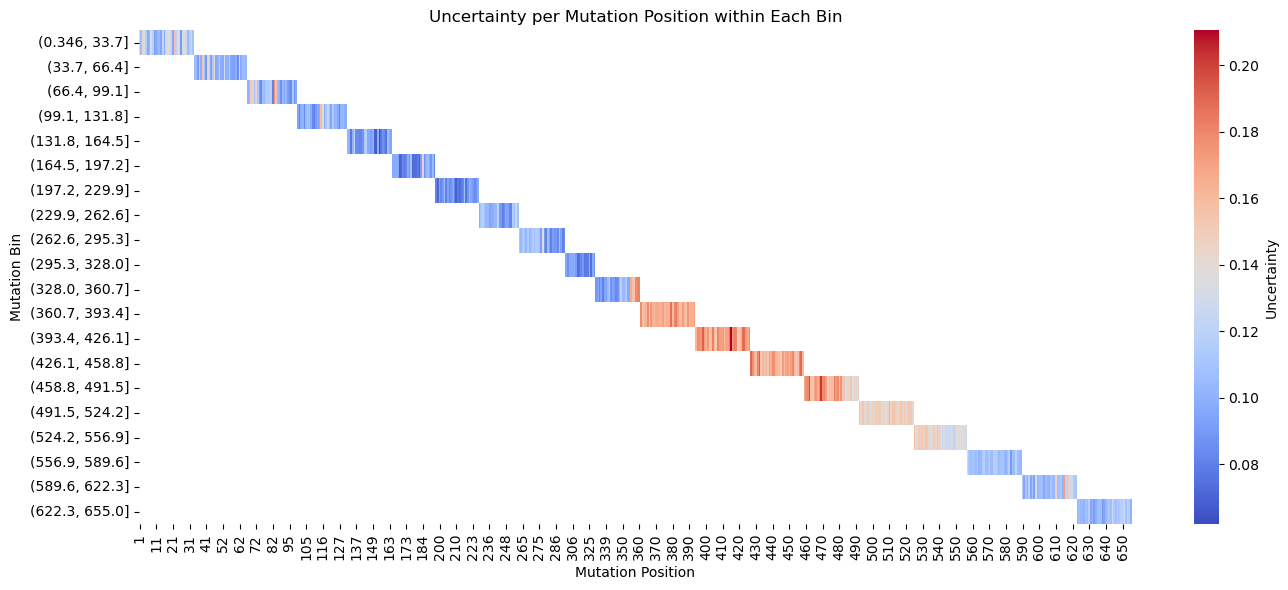

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# print(uncertainty)
# selected_indices, bald_scores = bald_acquisition(ensemble, unlabeled_loader, query_size)
df_test = test_df 
df_test['mutation_position'] = df_test['mutant'].apply(lambda x: int(x[1:-1]))
 
# --- Incorporate uncertainty estimates ---
# Here, we assume that the order of uncertainty estimates corresponds to the rows in df_test.
df_test['uncertainty'] = std_test#*4 + mean_test
# df_test['uncertainty'] = expected_improvement(mean_test, std_test, np.max(mean_test))
 
# --- Bin the data based on mutation position ---
num_bins = 20  # Adjust as needed
df_test['mutation_bin'] = pd.cut(df_test['mutation_position'], bins=num_bins)
 
# --- Aggregate uncertainty per bin ---
# Compute the average uncertainty per bin.
bin_uncertainty = df_test.groupby('mutation_bin')['uncertainty'].mean()
 
# --- Plot the uncertainty for each mutation bin ---
heatmap_data = df_test.pivot_table(index='mutation_bin', columns='mutation_position', values='uncertainty')
 
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty'})
plt.title('Uncertainty per Mutation Position within Each Bin')
plt.xlabel('Mutation Position')
plt.ylabel('Mutation Bin')
plt.tight_layout()
plt.show()

In [5]:
uncertainty = df_test['uncertainty'].to_numpy()
top_100_indices = np.argsort(uncertainty)[-150:][::-1]
print(top_100_indices)
top_100_mutants = test_df.iloc[top_100_indices].copy()
top_100_mutants['prediction_std'] = uncertainty[top_100_indices]
print(top_100_mutants)
top_100_mutants['mutant'].to_csv("top_100_predictions_2.csv", index=False)
 
import pandas as pd
 
# Load the CSV file
df_predictions = pd.read_csv('top_100_predictions_2.csv')
 
# Extract the 'mutant' column from the CSV file
mutants_predictions = df_predictions['mutant'].tolist()
 
# Load the text file
with open('query_merged.txt', 'r') as file:
    mutants_query = [line.strip() for line in file.readlines()]
 
# Convert both lists to sets for easier comparison
set_predictions = set(mutants_predictions)
set_query = set(mutants_query)
 
# 1. Common mutants
common_mutants = set_predictions.intersection(set_query)
print(f"Common mutants: {common_mutants}\n")

 
# 2. Mutants in query.txt but not in top_100_predictions_2.csv
mutants_in_query_not_in_predictions = set_query - common_mutants#set_predictions
print(f"Mutants in query but not in predictions: {mutants_in_query_not_in_predictions}\n")
 
# 3. Mutants in top_100_predictions_2.csv but not in query.txt
mutants_in_predictions_not_in_query = set_predictions - set_query
print(f"Mutants in predictions but not in query: {mutants_in_predictions_not_in_query}\n")
 
# 4. Count of common mutants
print(f"Number of common mutants: {len(common_mutants)}")
 
# 5. Count of mutants in query.txt but not in top_100_predictions_2.csv
print(f"Number of mutants in query but not in predictions: {len(mutants_in_query_not_in_predictions)}")
 
# 6. Count of mutants in top_100_predictions_2.csv but not in query.txt
print(f"Number of mutants in predictions but not in query: {len(mutants_in_predictions_not_in_query)}")

[ 3215  2092    73   738 10084   400 10547  5902 10200   416  4603   795
  9778 10085  8048  3836  2568  9834   739  9827   781     1  3232  8278
    69    11 10199  9832 10236  9806  7414   359  7025 10161  3827 11251
  9829  9724  1542  9848   312  9825  2567  9854  2565   459  9930 11104
  2133  1666   736  9853 10759  7166  9767 10106     5  9624   532   607
  8999  9752 11252 11218 11206   801 11233  7661  1653  2094   803 10059
  5591  3231    38   548  2090  9824 11040 10202  9686  8884  9855  2093
 10109 10239  2566 10112   527  9637 11229  9638 11173  9626 10316  8238
 10291  8217  9776 10223 11232  7856  9979 11285   735  9633  7017  8043
   307 10249 10107  6502  1548  9844 10192 10261  9828 11244  9639 10088
  7672 11238  9991  9640 10037  6966 10162  8105 10113 10193   544 10076
 11291  6012   724 10293  9978 10114  6095  8236  9700  9782   440  2576
  9975 10769 10198  7047 11271  9906]
      mutant  predicted  uncertainty  mutation_position    mutation_bin  \
3215   S183

In [6]:
mutants_in_predictions_not_in_query.intersection(set_query)

set()

In [8]:
mutants_in_predictions_not_in_query

{'A588T',
 'A649V',
 'A654V',
 'E39M',
 'E39N',
 'E39V',
 'E39Y',
 'E567A',
 'E567Q',
 'E567S',
 'E567T',
 'E567V',
 'E585A',
 'E585Q',
 'E585T',
 'E585V',
 'E592A',
 'E592S',
 'E592T',
 'E592V',
 'E599M',
 'E600T',
 'E601A',
 'E601V',
 'E651A',
 'E651C',
 'E651H',
 'E651W',
 'E653A',
 'E653F',
 'F581M',
 'I569V',
 'I591V',
 'I591Y',
 'K143V',
 'K143Y',
 'K596M',
 'K596P',
 'K596V',
 'K596W',
 'L533I',
 'L589I',
 'N486Q',
 'P354F',
 'P370R',
 'P495R',
 'P571S',
 'P576R',
 'P626F',
 'Q570H',
 'R376I',
 'R43V',
 'R566I',
 'R566K',
 'S17V',
 'S29W',
 'S426I',
 'S429H',
 'S429R',
 'S483Q',
 'S492H',
 'S493K',
 'S493M',
 'S578A',
 'S578I',
 'S578K',
 'S578P',
 'S578T',
 'S602R',
 'T450R',
 'T463K',
 'T463R',
 'T652W',
 'V116T',
 'V116W',
 'V1W',
 'V430I',
 'V473I',
 'V527A',
 'V573M',
 'V574K',
 'V574R',
 'V574W',
 'V577C',
 'V577F',
 'V577T',
 'V577W',
 'V92F',
 'V92W',
 'W380Q',
 'W582A',
 'W590C',
 'W590M',
 'W594A',
 'W594Y',
 'Y118F',
 'Y402F',
 'Y437F',
 'Y598C',
 'Y598W'}

In [7]:
with open('query.txt', 'w', encoding='utf-8') as f:
    for mut in mutants_in_predictions_not_in_query:
        f.write(mut + '\n')